# ROC Analysis

In [21]:
VERSION = 'roc_analysis'

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
%matplotlib inline

In [24]:
# all imports
import sys
sys.path.insert(0, '../src/')

import pandas as pd
import os
import transformers
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from transformers import (ModelTransformer, DataFrameColumnExtractor, ToDictTransformer)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn import cross_validation as cv
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
# from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

### Read data

In [25]:
DATA_DIR = '../data/raw/'
TRAIN_DATASET_PATH = os.path.join(DATA_DIR, 'train.csv')

In [26]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, encoding='utf-8')

In [27]:
X = df_train.drop(['y', 'id'], axis=1)
y = df_train['y']

### Define model

In [28]:
CATEGORICAL_FEATURES = [
    'job',
    'marital',
    'education',
    'default',
    'housing',
    'loan',
    'contact',
    'poutcome',
    'month',
    'day_of_week'
]

NUMERIC_FEATURES = [                    
    'age',
    'pdays',
    'emp.var.rate',
    'cons.price.idx',
    'cons.conf.idx',
    'euribor3m',
    'nr.employed',
    'campaign',
    'previous'
]


TRAINING_FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
ALL_COLUMNS = TRAINING_FEATURES + ['id', 'y']

In [29]:
transformer = make_pipeline(
    make_pipeline(
        make_union(
            make_pipeline(
                DataFrameColumnExtractor(NUMERIC_FEATURES),
                StandardScaler(),
            ),
            make_pipeline(
                DataFrameColumnExtractor(CATEGORICAL_FEATURES),
                ToDictTransformer(),
                DictVectorizer(sparse=False)
            ),
        )
    )
)

In [30]:
lr_pipeline = Pipeline([
    ('transformer', transformer),
    ('lr', LogisticRegression(random_state=42))
])

In [31]:
mlp_pipeline = Pipeline([
    ('transformer', transformer),
    ('mlp', MLPClassifier(random_state=42))
])

In [32]:
rf_pipeline = Pipeline([
    ('transformer', transformer),
    ('rf', RandomForestClassifier(random_state=42))
])

### Train Model

In [33]:
X_train, X_test, y_train, y_test = cv.train_test_split(X,
                                                       y,
                                                       test_size=0.25,
                                                       random_state=42)

In [34]:
lr_pipeline.fit(X_train, y_train)
mlp_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer', Pipeline(steps=[('pipeline', Pipeline(steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline-1', Pipeline(steps=[('dataframecolumnextractor', DataFrameColumnExtractor(columns=['age', 'pdays', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'eurib...stimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))])

### Predict

In [35]:
y_lr_pred = lr_pipeline.predict(X_test)
y_lr_pred_proba = lr_pipeline.predict_proba(X_test)

In [36]:
y_mlp_pred = mlp_pipeline.predict(X_test)
y_mlp_pred_proba = mlp_pipeline.predict_proba(X_test)

In [37]:
y_rf_pred = rf_pipeline.predict(X_test)
y_rf_pred_proba = rf_pipeline.predict_proba(X_test)

### ROC Analysis

In [38]:
preds_lr = y_lr_pred_proba[:,1]
fpr_lr, tpr_lr, threshold_lr = metrics.roc_curve(y_test, preds_lr)
roc_auc_lr = metrics.auc(fpr_lr, tpr_lr)

In [39]:
preds_mlp = y_mlp_pred_proba[:,1]
fpr_mlp, tpr_mlp, threshold_mlp = metrics.roc_curve(y_test, preds_mlp)
roc_auc_mlp = metrics.auc(fpr_mlp, tpr_mlp)

In [40]:
preds_rf = y_rf_pred_proba[:,1]
fpr_rf, tpr_rf, threshold_rf = metrics.roc_curve(y_test, preds_rf)
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)

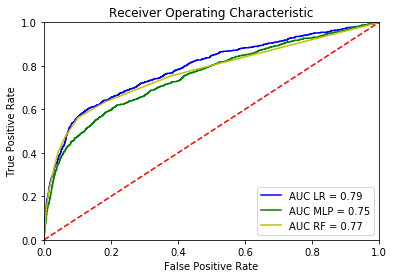

In [41]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC LR = %0.2f' % roc_auc_lr)
plt.plot(fpr_mlp, tpr_mlp, 'g', label = 'AUC MLP = %0.2f' % roc_auc_mlp)
plt.plot(fpr_rf, tpr_rf, 'y', label = 'AUC RF = %0.2f' % roc_auc_rf)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Classification report

In [42]:
# print(metrics.classification_report(y_test, y_lr_pred))
print("Precision: "+ str(metrics.precision_score(y_test, y_lr_pred)))
print("Recall: "+ str(metrics.recall_score(y_test, y_lr_pred)))
print("F1 Score: "+ str(metrics.f1_score(y_test, y_lr_pred, average='weighted')))

Precision: 0.6628571428571428
Recall: 0.23553299492385787
F1 Score: 0.8828430487781967


In [43]:
# print(metrics.classification_report(y_test, y_mlp_pred))
print("Precision: "+ str(metrics.precision_score(y_test, y_mlp_pred)))
print("Recall: "+ str(metrics.recall_score(y_test, y_mlp_pred)))
print("F1 Score: "+ str(metrics.f1_score(y_test, y_mlp_pred, average='weighted')))

Precision: 0.55470737913486
Recall: 0.22131979695431472
F1 Score: 0.8755578497779859


In [44]:
# print(metrics.classification_report(y_test, y_rf_pred))
print("Precision: "+ str(metrics.precision_score(y_test, y_rf_pred)))
print("Recall: "+ str(metrics.recall_score(y_test, y_rf_pred)))
print("F1 Score: "+ str(metrics.f1_score(y_test, y_rf_pred, average='weighted')))

Precision: 0.5847619047619048
Recall: 0.3116751269035533
F1 Score: 0.8874340295119506


### Conclusões

Pela maior valor de AUC, podemos ver que a regressão logística tem uma performance geral melhor.

Também podemos observar que para threshoslds menores, com False Postives abaixo de 0.4, o MLP tem uma desvantagem tendo uma menor taxa de True Positives. Ou seja, se o negócio necessita um baixo valor de falso positivo, o MLP, com essas configurações e tratamento de dados, não é a melhor escolha.

É possível que um classificador com maior AUC tenha uma performance pior em um região especifica do espaço ROC, porém, neste caso, o classificador com maior AUC (LR com 0.79 de AUC), é melhor em todo o espaço.

Essa foi uma análise simples, o ideal é que fosse medido a média de curvas ROC, porém essas informações já complementam a métrica de precision, recall e F1-Score.